In [0]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.compat.v1.keras import Sequential, Model, layers
from tensorflow.compat.v1.keras.layers import AveragePooling2D, Input, BatchNormalization, Flatten, MaxPooling2D
from tensorflow.compat.v1.keras.activations import relu as ReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import Callback
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, log_loss
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('drive/My Drive/cifar_10_data')

### Image Augmentation

In [0]:
# datagen = ImageDataGenerator(
#         rotation_range=10,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')

# augmented_images = np.array([])
# augmented_labels = np.array([])

# i = 0
# for batches in datagen.flow(train_data, train_labels, batch_size = 32, seed = 2):
#     if i>2000:
#         break
#     if augmented_images.shape[0] == 0:
#         augmented_images = batches[0]
#         augmented_labels = batches[1]
#     augmented_images = np.vstack((augmented_images, batches[0]))
#     augmented_labels = np.vstack((augmented_labels, batches[1]))
#     i+=1

# data = np.vstack((data, augmented_images))
# labels = np.vstack((labels, augmented_labels))

# indexes = np.arange(data.shape[0])
# np.random.seed(15)
# np.random.shuffle(indexes)

# data = data[indexes]
# labels = labels[indexes]

# with open('augmented_images.pickle', 'wb') as file:
#     pickle.dump([data, labels], file)

# with open('augmented_images.pickle', 'rb') as file:
#     x = pickle.load(file)

In [0]:
with open('augmented_data.pickle', 'rb') as file:
    data, labels = pickle.load(file)

In [0]:
indexes = np.arange(data.shape[0])
np.random.seed(15)
np.random.shuffle(indexes)

X_train = data[indexes]
y_train = labels[indexes]

In [0]:
y_train = to_categorical(y_train)

In [0]:
with open('new_data.pickle', 'rb') as file:
    _, __, X_test, y_test = pickle.load(file)

In [0]:
X_test = X_test.reshape((X_test.shape[0], 32, 32, 3), order = 'F').transpose(0, 2, 1, 3)/255

In [0]:
class_names = ['airplane',										
'automobile'	,									
'bird'		,								
'cat'					,					
'deer'	,									
'dog'		,								
'frog'	,									
'horse'	,						
'ship'	,									
'truck']

In [0]:
def composite_function(input):
    batch_norm = BatchNormalization()(input)
    relu = ReLU(batch_norm)
    conv = layers.Conv2D(filters = 4*k, kernel_size = 1, padding = 'same', 
                         kernel_initializer='he_normal')(relu)
    if not data_augmentation:
      conv = layers.Dropout(0.2)(conv)
    #####
    batch_norm = BatchNormalization()(conv)
    relu = ReLU(batch_norm)
    conv = layers.Conv2D(filters = k, kernel_size = 3, padding = 'same',
                         kernel_initializer='he_normal')(relu)
    if not data_augmentation:
        conv = layers.Dropout(0.2)(conv)
    return conv

def transition_layer(input):
    batch_norm = BatchNormalization()(input)
    conv = layers.Conv2D(filters = int(0.5*input.get_shape()[3].value),kernel_size = 1)(batch_norm)
    if not data_augmentation:
        conv = layers.Dropout(0.2)(conv)
    avg = AveragePooling2D(pool_size = (2, 2))(conv)
    return avg
    

In [11]:
k = 12
L = 16
n_blocks = 3
data_augmentation = True
input = Input(shape = (32, 32, 3))
_input = BatchNormalization()(input)
_input = ReLU(_input)
_input = layers.Conv2D(filters = 2*k, kernel_size = 3, padding = 'same', 
                       kernel_initializer='he_normal')(_input)

transition_inputs = [layers.concatenate([input, _input], axis = 3)]
for block_number in range(n_blocks):
    dense_inputs = [transition_inputs[-1]]
    for i in range(L):
        if len(dense_inputs) == 1:
            comp_output = composite_function(dense_inputs[-1])
        else:
            comp_output = composite_function(layers.concatenate(dense_inputs[::-1], axis = 3))
        dense_inputs.append(comp_output)
    if block_number == n_blocks - 1:
        continue
    transition_inputs.append(transition_layer(layers.concatenate(dense_inputs, axis = 3)))
pool = AveragePooling2D(pool_size = (8, 8))(layers.concatenate(dense_inputs[::-1], axis = 3))    
flat = Flatten()(pool)
#dense = layers.Dense(100)(flat)
output = layers.Dense((10), activation = 'softmax')(flat)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model = Model(inputs = input, outputs = output)
#Optimizer reference - https://github.com/titu1994/DenseNet/blob/master/cifar10.py
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-3),
              metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=np.sqrt(0.1),
                                    cooldown=0, patience=5, min_lr=1e-5)

In [0]:
acc = []
loss = []

In [0]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs = {}):
        global acc, loss
        acc.append(logs.get('val_acc'))
        loss.append(logs.get('val_loss'))
        if (logs.get('val_acc') >= 0.90) or (epoch % 10 == 0) :
            print("\nSaving Model")
            self.model.save(f"new_dense-model-{epoch}.hdf5")
            print("Continuing.......")
callback = MyCallback()

model.fit(X_train, y_train,epochs = 300,batch_size = 100
          , verbose = 1, callbacks = [callback, reduce_lr], validation_data=(X_test, y_test))

Train on 100000 samples, validate on 10000 samples


In [0]:
# with open('acc.pickle', 'wb') as file:
#   pickle.dump([acc, loss], file)

with open('acc.pickle', 'rb') as file:
  acc, loss = pickle.load(file)

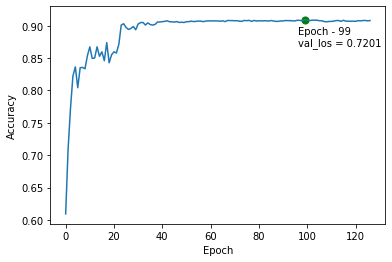

In [11]:
plt.plot(acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.scatter(99, acc[99], s=50, marker='o', c='green')
plt.text(99-3, acc[99]-0.04, f'Epoch - 99\nval_los = {round(loss[99], 4)}')
plt.show()

In [12]:
#Loading the Model
model = load_model('new_dense-model-99.hdf5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict_class = train_predict.argmax(axis = 1)
test_predict_class = test_predict.argmax(axis = 1)

In [14]:
print(f"Train accuracy - {accuracy_score(y_train.argmax(axis = 1), train_predict_class)}")
print(f"Train accuracy - {log_loss(y_train, train_predict)}")

print(f"Test accuracy - {accuracy_score(y_test.argmax(axis = 1), test_predict_class)}")
print(f"Test accuracy - {log_loss(y_test, test_predict)}")

Train accuracy - 1.0
Train accuracy - 3.09944249015075e-07
Test accuracy - 0.9093
Test accuracy - 0.7173230132425321


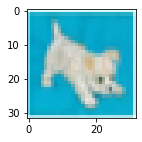

In [15]:
plt.figure(figsize = (2, 2))
plt.imshow(X_test[1019])
plt.show()

In [16]:
class_names[model.predict(X_test[1019][np.newaxis,:]).argmax()]

'dog'

### Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test.argmax(axis = 1), test_predict_class)

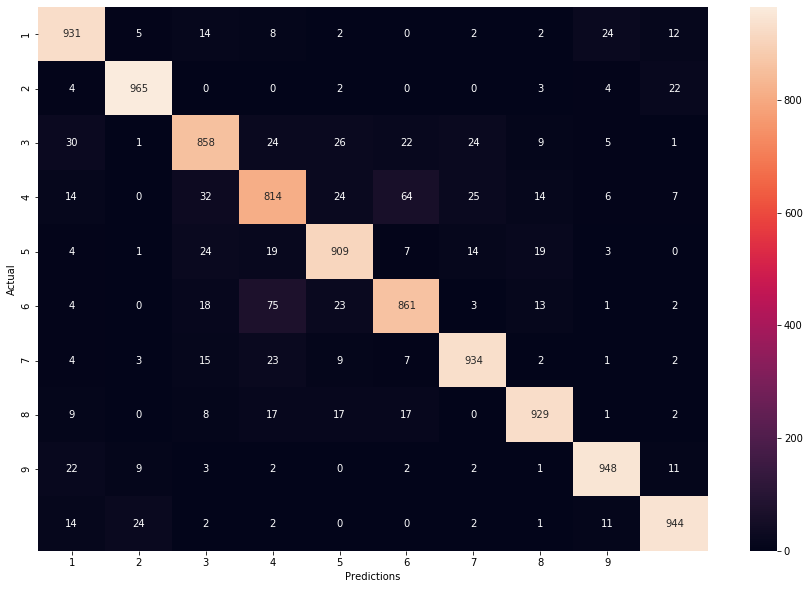

In [18]:
import seaborn as snb
plt.figure(figsize = (15, 10))
snb.heatmap(conf_matrix, annot = True, fmt = 'd', xticklabels = range(1, 10) ,yticklabels = range(1, 10))
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.show()

### References

* https://arxiv.org/pdf/1608.06993.pdf
* https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/densenet-cifar10-2.4.1.py